In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.stats import norm,geom
import math
from matplotlib import pyplot as plt
from scipy.stats.kde import gaussian_kde
from numpy import linspace
import seaborn as sns
from scipy.interpolate import interp1d
from matplotlib.backends.backend_pdf import PdfPages  
from sklearn.metrics import precision_score, \
recall_score, confusion_matrix, classification_report, \
accuracy_score, f1_score

### Getting the master data for Gender , Age and  Operation Type

In [6]:
master_data = pd.read_csv('MASTER_DATASET.csv')
master_data['Age']=''
master_data.loc[master_data['Age at Encounter'] <= 40, 'Age'] = '40 and Below'
master_data.loc[((master_data['Age at Encounter'] >=40) & (master_data['Age at Encounter'] <=70)), 'Age'] = '70 and Below'
master_data.loc[((master_data['Age at Encounter'] >=70)) , 'Age'] = 'Above 70'
master_data=master_data[['RedCap_ID','Age','Sex','Service']]

### Extracting the data from the engineering logs

In [7]:
import os
rootdir = 'PCA Logs 1_20_17'
#1 hour time interval
time_interval=60
time_interval_secs=time_interval*60
df_demands_init=pd.DataFrame()
for subdir, dirs, files in os.walk(rootdir):
    for file in files:   
        #print (os.path.join(subdir, file))
        try:       
            print(subdir)
            xl = pd.ExcelFile(os.path.join(subdir, file)
                 ,skiprows=5,parse_cols="A,B,C,F" )
            sheet_name=xl.sheet_names[0]
            df = xl.parse(sheet_name,skiprows=4,parse_cols="A,B,C,F")

			#Folder name corresponds to the RedCap_ID of patient
            patient=subdir.split("\\",1)[1]
            xtract=master_data[master_data.RedCap_ID==patient]
			# KEYPRESS_ATTACHED is demand
            demands=df[df.Description=='KEYPRESS_ATTACHED']
            demands=demands.sort('Log Date')
			#The time difference from first demand
            demands['timeDiff']=pd.DataFrame(pd.to_datetime(demands['Log Date'])-pd.to_datetime(demands[['Log Date']].iloc[0][0])).astype('timedelta64[s]')
			
			#Count the number of demands in time interval
            cnt=pd.DataFrame(demands['timeDiff']/time_interval_secs).astype(int)
            cnt['num_dmd']=''
            temp_df=cnt.groupby('timeDiff').count()
            temp_df=temp_df.reset_index()
            temp_df['RedCap_ID']=patient
            temp_df['Sex']=xtract['Sex'].tolist()[0]
            temp_df['Age']=xtract['Age'].tolist()[0]
            temp_df['Service']=xtract['Service'].tolist()[0]
            df_demands_init=df_demands_init.append(temp_df)
        except:
            print("Error")

//anes.ahc.ufl.edu/anes$/SHARE/research/Tighe Lab/Tempos/PCA Logs 1_20_17
Error
//anes.ahc.ufl.edu/anes$/SHARE/research/Tighe Lab/Tempos/PCA Logs 1_20_17\TEMPOS-07
Error
//anes.ahc.ufl.edu/anes$/SHARE/research/Tighe Lab/Tempos/PCA Logs 1_20_17\TEMPOS-07


C:\Users\Shruthi\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


//anes.ahc.ufl.edu/anes$/SHARE/research/Tighe Lab/Tempos/PCA Logs 1_20_17\TEMPOS-101
//anes.ahc.ufl.edu/anes$/SHARE/research/Tighe Lab/Tempos/PCA Logs 1_20_17\TEMPOS-14
Error
//anes.ahc.ufl.edu/anes$/SHARE/research/Tighe Lab/Tempos/PCA Logs 1_20_17\TEMPOS-15
Error
//anes.ahc.ufl.edu/anes$/SHARE/research/Tighe Lab/Tempos/PCA Logs 1_20_17\TEMPOS-16
Error
//anes.ahc.ufl.edu/anes$/SHARE/research/Tighe Lab/Tempos/PCA Logs 1_20_17\TEMPOS-16
Error
//anes.ahc.ufl.edu/anes$/SHARE/research/Tighe Lab/Tempos/PCA Logs 1_20_17\TEMPOS-18
Error
//anes.ahc.ufl.edu/anes$/SHARE/research/Tighe Lab/Tempos/PCA Logs 1_20_17\TEMPOS-21
Error
//anes.ahc.ufl.edu/anes$/SHARE/research/Tighe Lab/Tempos/PCA Logs 1_20_17\TEMPOS-22
Error
//anes.ahc.ufl.edu/anes$/SHARE/research/Tighe Lab/Tempos/PCA Logs 1_20_17\TEMPOS-23
Error
//anes.ahc.ufl.edu/anes$/SHARE/research/Tighe Lab/Tempos/PCA Logs 1_20_17\TEMPOS-27
Error
//anes.ahc.ufl.edu/anes$/SHARE/research/Tighe Lab/Tempos/PCA Logs 1_20_17\TEMPOS-33
Error
//anes.ahc.ufl.

### Multiplying by 60 to convert it to the actual minutes

In [8]:
df_demands=df_demands_init[['RedCap_ID','timeDiff','num_dmd']]
df_demands['timeDiff']=df_demands['timeDiff']*time_interval

C:\Users\Shruthi\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


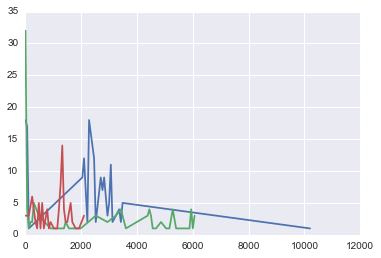

In [9]:
plt.plot(df_demands[df_demands.RedCap_ID=='TEMPOS-99']['timeDiff'],df_demands[df_demands.RedCap_ID=='TEMPOS-99']['num_dmd'])
plt.plot(df_demands[df_demands.RedCap_ID=='TEMPOS-101']['timeDiff'],df_demands[df_demands.RedCap_ID=='TEMPOS-101']['num_dmd'])
plt.plot(df_demands[df_demands.RedCap_ID=='TEMPOS-07']['timeDiff'],df_demands[df_demands.RedCap_ID=='TEMPOS-07']['num_dmd'])

In [10]:
df_demands=df_demands.set_index('RedCap_ID')

### Interpolating the values

In [11]:
def interpolate(time_series):
    interval = 30
    t_var = "timeDiff"
    val_var = "num_dmd"
    min_t = time_series[t_var].min()
    max_t = time_series[t_var].max() # d
    min_val = time_series[val_var].min()
    max_val = time_series[val_var].max()
    const_interval_T = np.arange(min_t, 
                                 max_t, 
                                 interval)
    interpolation_func = interp1d(x = time_series[t_var], 
                                  y = time_series[val_var])
    interpolated_vals = interpolation_func(const_interval_T)
    #print(interpolated_vals)
    try:
        interpolated_vals[interpolated_vals < min_val] = min_val # Don't go under the minimum observed value
        interpolated_vals[interpolated_vals > max_val] = max_val # Don't exceed the maximum observed value
    except:
         pass
    series_t_indexed = time_series.set_index(t_var)
    series_expanded = series_t_indexed.reindex(const_interval_T, 
                                               method = 'ffill')
    series_expanded[val_var] = interpolated_vals
    return series_expanded



In [12]:
interpolated = df_demands \
                .groupby(level = 0) \
                .apply(interpolate)

In [13]:
interpolated_reset=interpolated.reset_index()

In [14]:
interpolated_reset.set_index('RedCap_ID' , inplace=True)

In [15]:
interpolated_reset=interpolated_reset[['timeDiff','num_dmd']]

### PAA 

In [16]:
def piecewise_aggregate_approximation(time_series, r1, r2):
    #print(time_series)
    time_series = pd.Series(time_series.values) #disregard indices
    d = int(time_series.count())
    w = int(np.ceil(float(r1 * (d - 1)) / float(r2)))
    #print(w)
    # Take care of the special case where there is no dimensionality reduction
    paa=[]
    if d == 1 or w == d:
        paa = time_series
    else:
        if d % w == 0:
                paa = time_series.reshape([d // w, w], order="F").mean(axis=0)    
        else:
            try:
                temp = pd.DataFrame(time_series).T.reindex(index = range(w), method="ffill")
                expanded_sub_section = temp.values.reshape(w * d, order="F")
                paa = expanded_sub_section.reshape([d, w], order="F").mean(axis=0)
                #print(paa)
            except:
                print ("mistake")
    return pd.Series(paa)

In [17]:
frame_sizes=[60]
r2=60

In [18]:
r1=1
r2=60
piecewisegrp=pd.DataFrame()
redcapids=interpolated_reset.reset_index()['RedCap_ID'].unique()
for i in redcapids:
    df_fil=interpolated_reset.reset_index()[interpolated_reset.reset_index()["RedCap_ID"]==i]
    df_fil=df_fil.set_index('RedCap_ID')
    df_paa=df_fil.apply(piecewise_aggregate_approximation, r1 = r1, r2 = r2) 
    df_paa['RedCap_ID']=i
    piecewisegrp=piecewisegrp.append(df_paa,ignore_index=True)

mistake
mistake
mistake


In [24]:
rst=piecewisegrp.set_index('RedCap_ID')

In [25]:
def calculate_breakpoints(frame_size):
    all_paa = rst
    all_paa.columns = ["t", "value"]
    all_paa = all_paa.value
    beta = 8
    i_vals = np.arange(1, beta)
    breakpoints = [all_paa.min()] + [
        all_paa.quantile(i / float(beta))
        for i in i_vals
    ] + [np.inf]
    print(breakpoints)
    really_small_number = 1e-12
    for i in np.arange(1, beta):
        if breakpoints[i] <= breakpoints[i - 1]:
            if i > 1 and breakpoints[i] <=breakpoints[i - 2]:
                raise Exception("More than two adjacent bins are filled with the same value - don't know how to proceed.")
            # Fix the case where a bin contains only a single unique value by adding
            # a really small number to the lower boundary of the second bin
            # XXX: This is somewhat hacky and should be investigated if it happens to your data set
            breakpoints[i] = breakpoints[i] + really_small_number
    return breakpoints

beta = 8

#serial processing
breakpoints_list = [calculate_breakpoints(frame_size) for frame_size in frame_sizes]

#parallel processing (experimental)
#breakpoints_list = Parallel(n_jobs=multiprocessing.cpu_count())(
#    delayed(calculate_breakpoints)(frame_size) for frame_size in frame_sizes
#)


[1.0, 1.1276881720430108, 1.4601226993865031, 1.6775956284153004, 1.9285714285714284, 2.15625, 2.8517691514943317, 3.7499999999999996, inf]


In [26]:
breakpoints = {frame_size: breakpoint_array for frame_size, breakpoint_array in zip(frame_sizes, breakpoints_list)}

In [27]:
import string
def gen_sax_words(frame_size, breakpoints):
    paa = rst
    paa.columns = ["t", "value"]
    paa = paa.value
    
    cuts = paa.apply(lambda element: np.sum(breakpoints[frame_size] <= element))
    print(cuts)
    sax_flattened = cuts.apply(lambda cut: string.ascii_lowercase[cut - 1])
    sax_words = sax_flattened.groupby(level=0).apply(lambda series: "".join(series))
    return sax_words

#serial processing
sax_word_list = [gen_sax_words(frame_size, breakpoints) for frame_size in frame_sizes]

#parallel processing
#sax_word_list = Parallel(n_jobs=multiprocessing.cpu_count())(
#    delayed(gen_sax_words)(frame_size, breakpoints) for frame_size in frame_sizes
#)

sax_words = {frame_size: sax_word_array for frame_size, sax_word_array in zip(frame_sizes, sax_word_list)}

RedCap_ID
TEMPOS-07     6
TEMPOS-07     7
TEMPOS-101    7
TEMPOS-101    4
TEMPOS-101    6
TEMPOS-101    3
TEMPOS-52     5
TEMPOS-52     4
TEMPOS-52     8
TEMPOS-52     8
TEMPOS-52     8
TEMPOS-52     5
TEMPOS-54     8
TEMPOS-54     3
TEMPOS-57     5
TEMPOS-57     5
TEMPOS-57     2
TEMPOS-57     1
TEMPOS-59     7
TEMPOS-59     6
TEMPOS-59     1
TEMPOS-59     1
TEMPOS-61     6
TEMPOS-61     7
TEMPOS-62     5
TEMPOS-62     2
TEMPOS-62     2
TEMPOS-70     8
TEMPOS-70     7
TEMPOS-76     3
             ..
TEMPOS-77     1
TEMPOS-77     1
TEMPOS-77     1
TEMPOS-78     8
TEMPOS-78     5
TEMPOS-78     4
TEMPOS-78     4
TEMPOS-78     3
TEMPOS-78     2
TEMPOS-78     2
TEMPOS-78     1
TEMPOS-79     6
TEMPOS-79     7
TEMPOS-81     7
TEMPOS-81     2
TEMPOS-81     2
TEMPOS-81     3
TEMPOS-81     4
TEMPOS-94     4
TEMPOS-94     4
TEMPOS-94     6
TEMPOS-95     5
TEMPOS-95     2
TEMPOS-95     6
TEMPOS-99     8
TEMPOS-99     8
TEMPOS-99     8
TEMPOS-99     7
TEMPOS-99     6
TEMPOS-99     3
Name: value, d

In [28]:
def transition_pos(transition):
    beta = 8
    l = 2
    summation = 1
    for i in range(l):
        kj = string.ascii_lowercase.index(transition[i]) + 1 # Paper is 1-based, python is 0-based
        summation = summation + (kj - 1) * beta ** (l - i - 1)
    return summation

In [29]:
def count_transitions(sax_word):
    beta = 8
    l = 2
    counts = [0] * beta ** l
    for i in range(len(sax_word) - l + 1):
        transitions = sax_word[i:i+l]
        t_pos = transition_pos(transitions) - 1 # Paper is 1-based, python is 0-based
        counts[t_pos] = counts[t_pos] + 1
    return counts

In [30]:
frame_sizes=[60]

In [31]:
def gen_transition_count_matrix(frame_size, sax_words):
    return sax_words[frame_size].apply(lambda sax_word: pd.Series(count_transitions(sax_word)))

In [32]:
transition_count_matrix = {}
for frame_size in pd.Series(frame_sizes).sort(ascending=True, inplace=False).values:
    print(frame_size)
    transition_count_matrix[frame_size] = gen_transition_count_matrix(frame_size, sax_words)

60


C:\Users\Shruthi\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  from ipykernel import kernelapp as app


In [64]:
class_list=pd.merge(master_data, rst.reset_index(), on='RedCap_ID')

In [81]:
def ecdf(class_id, class_sizes, class_transition_importances, transition_count_matrix):
    n = 1000
    xrim_star_arr = []
    class_size = int(class_sizes.ix[class_id])
    for i in range(n):
        Pri = np.random.choice(transition_count_matrix.index, size = class_size, replace = True)
        M_star = transition_count_matrix.ix[Pri]
        x_star = M_star.sum() / M_star.sum().sum()
        xrim_star_arr.append(x_star)
    xrim_star = pd.DataFrame.from_records(xrim_star_arr)
    F_hat = 1.0 / n * (xrim_star < class_transition_importances.ix[class_id]).sum()
    return F_hat

In [82]:
groupingon=['Service','Age','Sex']

Urology
Pancreas & Biliary Surgery
Thoracic/Cardiovascular Surgery
Colorectal Surgery
Neurosurgery
Normalizing Urology
Normalizing Pancreas & Biliary Surgery
Normalizing Thoracic/Cardiovascular Surgery
Normalizing Colorectal Surgery
Normalizing Neurosurgery


C:\Users\Shruthi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\Shruthi\Anaconda3\lib\site-packages\ipykernel\__main__.py:40: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


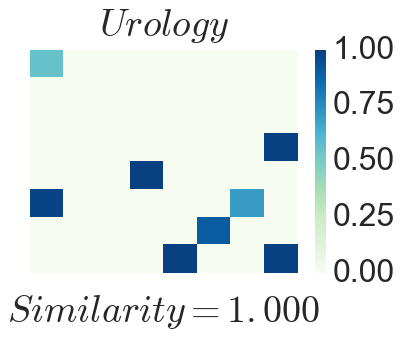

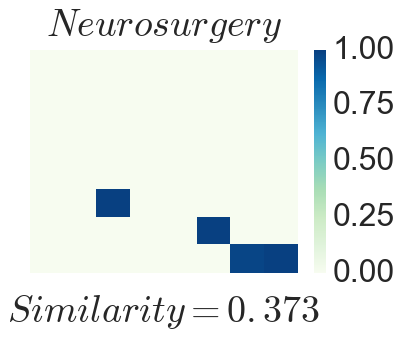

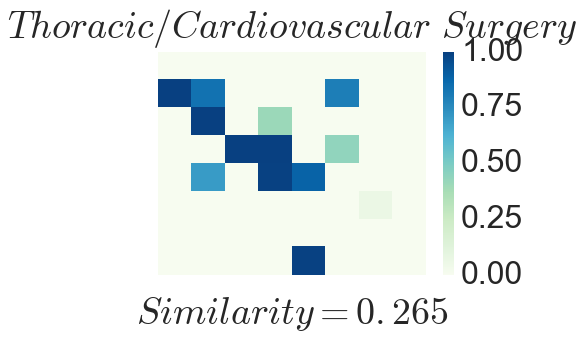

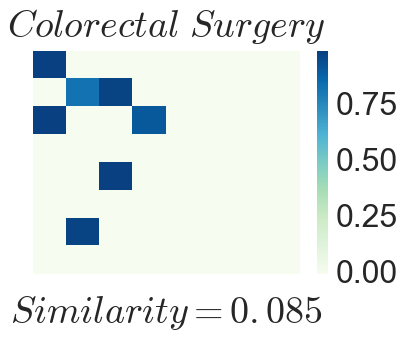

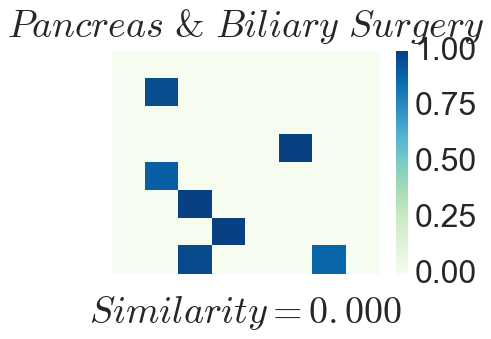

40 and Below
70 and Below
Above 70
Normalizing 40 and Below
Normalizing 70 and Below
Normalizing Above 70


C:\Users\Shruthi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


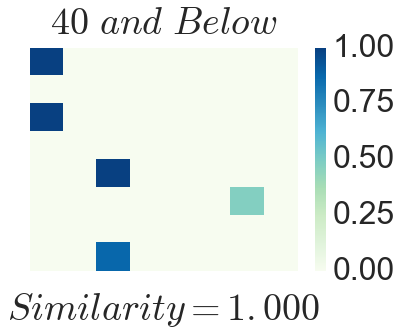

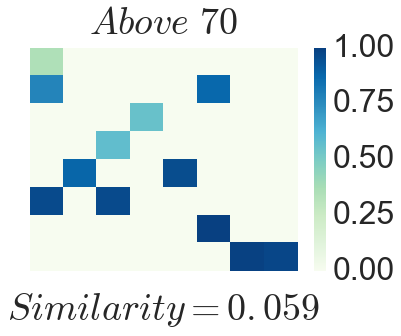

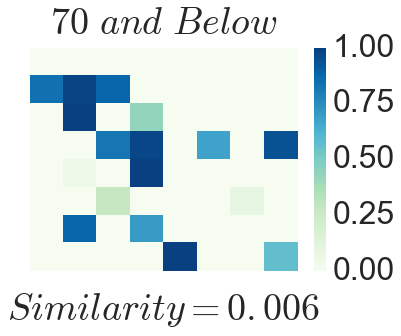

MALE
FEMALE
Normalizing MALE
Normalizing FEMALE


C:\Users\Shruthi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


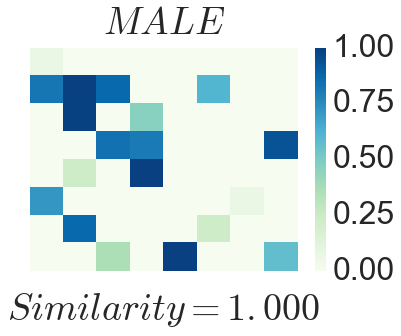

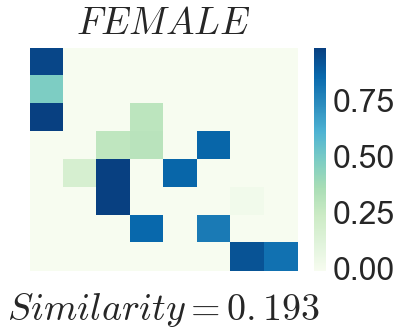

In [83]:
for g in groupingon:
    classes=class_list.reset_index()[g]
    unique_class_ids=classes.unique()
    ids_by_classes=class_list[['t','value','RedCap_ID',g]].set_index(g)
    paa_frame_size=60
    class_transition_importances_dict = {}
    for class_id in unique_class_ids:
        print(class_id)
        member_ids = ids_by_classes.ix[class_id].values.ravel()
        transition_counts = transition_count_matrix[paa_frame_size].ix[member_ids]
        transition_importances = transition_counts.sum() / transition_counts.sum().sum()
        class_transition_importances_dict[class_id] = transition_importances
    class_transition_importances = pd.DataFrame.from_dict(class_transition_importances_dict, orient = "index")
    class_transition_importances
    class_sizes = classes.value_counts()
    F_hats_arr = []
    for class_id in unique_class_ids:
        print("Normalizing " + str(class_id))
        F_hat = ecdf(class_id, class_sizes, class_transition_importances, transition_count_matrix[paa_frame_size])
        F_hat["class_id"] = class_id
        F_hats_arr.append(F_hat)
    F_hats = pd.DataFrame.from_records(F_hats_arr, index = "class_id")
    import string
    from sklearn.metrics.pairwise import cosine_similarity
    from joblib import Parallel, delayed
    import multiprocessing
    from subprocess import Popen, PIPE, STDOUT
    from multiprocessing import Process, Queue
    import os.path
    reference_class = 0
    similarities = pd.Series(cosine_similarity(X = F_hats.ix[reference_class], 
                                               Y = F_hats).ravel(), 
                             index = F_hats.index)
    from matplotlib.backends.backend_pdf import PdfPages
    reference_class = 1
    sort_by_similarity = True
    show_icon_similarities = True

    if sort_by_similarity:
        similarities.sort(ascending = False, inplace=True)
        classes_sorted = similarities.index
    else:
        #sort lexicographically by class id
        classes_sorted = similarities.sort_index().index

    for class_id in classes_sorted:
        icon = F_hats.ix[class_id]
        beta = 8
        icon_side = beta

        ax = plt.axes()
        #hide distracting axis ticks
        ax.tick_params(labelbottom='off',
                       labelleft='off')
        ax.set_title(label="$" + str(class_id).replace( ' ', '\ ').replace( "_", "\_") + "$", fontsize=38, y=1.04)
        if class_id != reference_class and show_icon_similarities:
            similarity = similarities[class_id]
            ax.set_xlabel(xlabel=r"$Similarity = " + ('%.3f' % similarity) + "$", \
                          fontsize=38, labelpad = 20)
        pixel_data = icon.reshape([icon_side, icon_side]).astype(float)
        heatmap = ax.pcolor(pixel_data, cmap = plt.get_cmap("GnBu"))
        ax.invert_yaxis()
        cbar = plt.colorbar(heatmap, ax=ax)
        cbar.ax.tick_params(labelsize=32)
        cbar.set_ticks(np.linspace(0, 1, 5))
        f=plt.show()
